In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
import tensorflow as tf
import tensorflow_probability as tfp
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
tf.enable_eager_execution()

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def print_subclass_from_module(module, base_class, max_width=80):
    import functools, inspect, sys
    subclasses = [name for name, obj in inspect.getmembers(module)
                  if inspect.isclass(obj) and issubclass(obj, base_class)]
    def red(acc, x):
        if not acc or len(acc[-1]) + len(x) + 2 > max_width:
            acc.append(x)
        else:
            acc[-1] += ", " + x
        return acc
    print("\n".join(functools.reduce(red, subclasses, [])))

In [3]:
print_subclass_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchReshape, Bernoulli, Beta, Binomial, Blockwise, Categorical
Cauchy, Chi, Chi2, Chi2WithAbsDf, ConditionalDistribution
ConditionalTransformedDistribution, Deterministic, Dirichlet
DirichletMultinomial, Distribution, Empirical, ExpRelaxedOneHotCategorical
Exponential, FiniteDiscrete, Gamma, GammaGamma, GaussianProcess
GaussianProcessRegressionModel, Geometric, Gumbel, HalfCauchy, HalfNormal
HiddenMarkovModel, Horseshoe, Independent, InverseGamma, InverseGaussian
JointDistribution, JointDistributionCoroutine, JointDistributionNamed
JointDistributionSequential, Kumaraswamy, LKJ, Laplace
LinearGaussianStateSpaceModel, LogNormal, Logistic, Mixture, MixtureSameFamily
Multinomial, MultivariateNormalDiag, MultivariateNormalDiagPlusLowRank
MultivariateNormalDiagWithSoftplusScale, MultivariateNormalFullCovariance
MultivariateNormalLinearOperator, MultivariateNormalTriL
MultivariateStudentTLinearOperator, NegativeBinomial, Normal, OneHotCategorical
Pareto, Poisson, PoissonLogNo

In [4]:
tf.test.gpu_device_name()  # check hardware acceleration

'/device:GPU:0'

In [5]:
# a = tf.constant(np.pi)
# b = tf.constant(np.e)
# with tf.GradientTape() as tape:
#     tape.watch([a, b])
#     c = 0.5 * (a ** 2 + b ** 2)
# grads = tape.gradient(c, [a, b])
# print(grads[0].numpy())
# print(grads[1].numpy())

## 1. Distributions

### A simple scalar-variate Distribution

tfp.distributions.Normal("Normal/", batch_shape=[], event_shape=[], dtype=float32)


Text(0.5, 1.0, 'Samples from a standard normal')

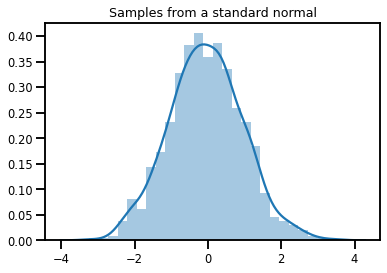

In [6]:
normal = tfd.Normal(loc=0, scale=1.)
print(normal)

samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard normal")

In [7]:
print(normal.log_prob(0.).numpy())
print(normal.log_prob([-1, 0, 1]).numpy())

print(ss.norm(0, 1).logpdf(0))
print(ss.norm(0, 1).logpdf([-1, 0, 1]))

-0.9189385
[-1.4189385 -0.9189385 -1.4189385]
-0.9189385332046727
[-1.41893853 -0.91893853 -1.41893853]


### Distributions and Shapes

In [8]:
normals = tfd.Normal([-2.5, 0, 2.5], 1.)
print(normals.batch_shape)
print(normals.event_shape)

(3,)
()


In [9]:
samples = normals.sample(1000)
print(samples.shape)

samples = normals.sample([10, 10, 100])
print(samples.shape)

(1000, 3)
(10, 10, 100, 3)


In [10]:
print(normals.log_prob([-2.5, 0, 2.5]))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


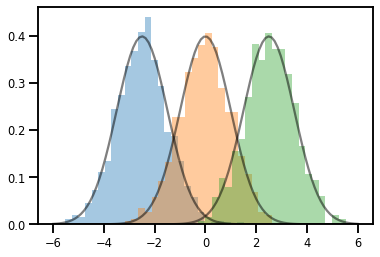

In [11]:
x = np.linspace(-6, 6, 100).reshape(-1, 1)
samples = normals.sample(1000)
for i in range(3):
    sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(x, 3), normals.prob(x), c="k", alpha=0.5)

### A vector-variable `Distribution`

()
(2,)
(1000, 2)


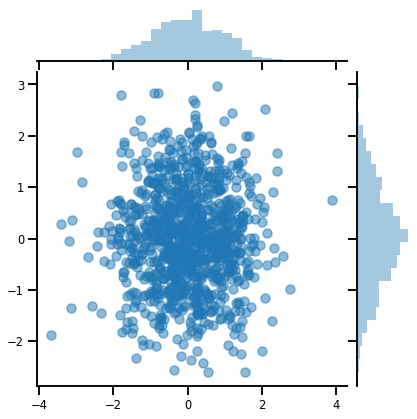

In [12]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
print(mvn.batch_shape)
print(mvn.event_shape)

samples = mvn.sample(1000)
print(samples.shape)


sns.jointplot(samples[:, 0], samples[:, 1], kind="scatter", alpha=0.5)

### A matrix-variate `Distribution`

In [13]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print(lkj.batch_shape)
print(lkj.event_shape)

(2,)
(10, 10)


(1, 2, 10, 10)


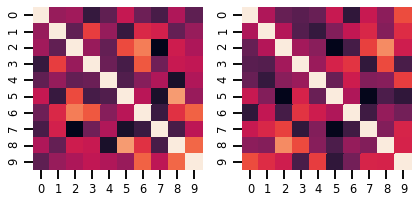

In [14]:
samples = lkj.sample(1)
print(samples.shape)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3))

for i in range(2):
    sns.heatmap(samples[0][i], ax=axes[i], cbar=False)
fig.tight_layout()

### Gaussian Processes

In [15]:
kernel = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic()
x = np.linspace(-5, 5, 200).reshape(-1, 1)
gp = tfd.GaussianProcess(kernel, index_points=x)
print(gp.batch_shape)
print(gp.event_shape)

()
(200,)


Text(0.5, 1.0, 'GP prior mean, $2\\sigma$ intervals and samples')

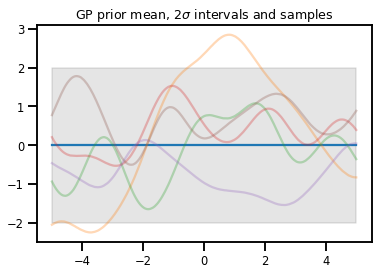

In [16]:
upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(x, gp.mean())
plt.fill_between(x.reshape(-1), lower, upper, color="k", alpha=0.1)
for _ in range(5):
    plt.plot(x, gp.sample(), alpha=0.3)
plt.title(r"GP prior mean, $2\sigma$ intervals and samples")

### GP Regression

In [18]:
obs_x = np.array([-3., 0., 2.]).reshape(-1, 1)
obs_y = np.array([3., -2., 2.])

gprm = tfd.GaussianProcessRegressionModel(kernel, x, obs_x, obs_y)

Text(0.5, 1.0, 'GP posterior mean, $2\\sigma$ intervals and samples')

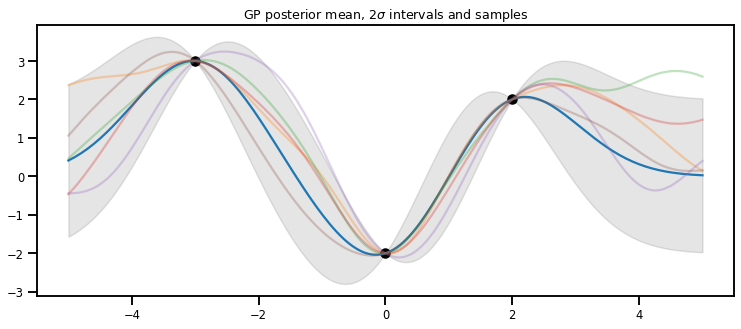

In [24]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.figure(figsize=(12.5, 5))
plt.plot(x, gprm.mean())
plt.fill_between(x.reshape(-1), lower, upper, color="k", alpha=0.1)
for _ in range(5):
    plt.plot(x, gprm.sample(), alpha=0.3)
plt.scatter(obs_x.reshape(-1), obs_y, c="k")
plt.title(r"GP posterior mean, $2\sigma$ intervals and samples")


## 2. Bijectors

In [25]:
print_subclass_from_module(tfb, tfb.Bijector)

AbsoluteValue, Affine, AffineLinearOperator, AffineScalar, BatchNormalization
Bijector, Blockwise, Chain, CholeskyOuterProduct, CholeskyToInvCholesky
ConditionalBijector, CorrelationCholesky, Cumsum, DiscreteCosineTransform, Exp
Expm1, FillTriangular, Gumbel, Identity, Inline, Invert, IteratedSigmoidCentered
Kumaraswamy, MaskedAutoregressiveFlow, MatrixInverseTriL, MatvecLU, NormalCDF
Ordered, Permute, PowerTransform, RealNVP, Reciprocal, Reshape, ScaleTriL
Sigmoid, SinhArcsinh, SoftmaxCentered, Softplus, Softsign, Square, Tanh
TransformDiagonal, Transpose, Weibull


### A simple bijector

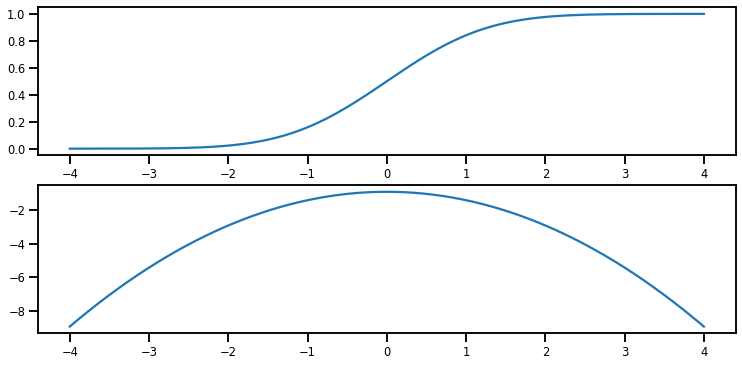

In [30]:
normal_cdf = tfb.NormalCDF()
x = np.linspace(-4, 4, 200)

plt.figure(figsize=(12.5, 6))
plt.subplot(211)
plt.plot(x, normal_cdf.forward(x))

plt.subplot(212)
plt.plot(x, normal_cdf.forward_log_det_jacobian(x, event_ndims=0))

### A bijector transforming a distribution

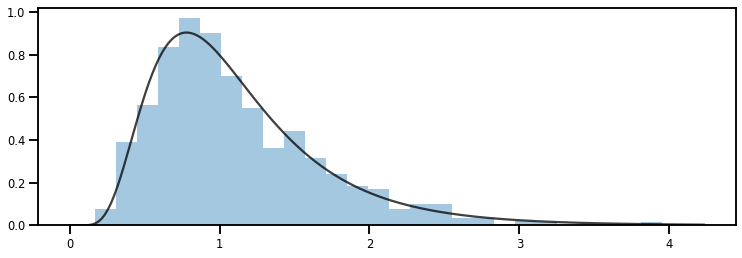

In [41]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))

samples = log_normal.sample(1000)

plt.figure(figsize=(12.5, 4))
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)

### Batching Bijectors

(200, 3)


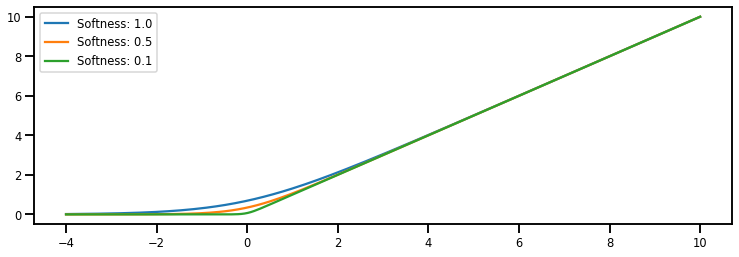

In [49]:
hinge_softness=[1., .5, .1]
softplus = tfb.Softplus(hinge_softness)
x = np.linspace(-4, 10, 200).reshape(-1, 1)
y = softplus.forward(x)
print(y.shape)

plt.figure(figsize=(12.5, 4))
for i in range(len(hinge_softness)):
    plt.plot(x, y[:, i], label=f"Softness: {hinge_softness[i]}")
plt.legend()

### Caching

In [53]:
# This bijector represents a matrix outer product on the forward pass,
# and a cholesky decomposition on the inverse pass. The latter costs O(N^3)!
bij = tfb.CholeskyOuterProduct()
size = 2500
# Make a big, lower-triangular matrix
big_lower_triangular = tf.eye(size)
# Squaring it gives us a positive-definite matrix
big_positive_definite = bij.forward(big_lower_triangular)

In [56]:
%timeit -r 5 -n 5 tf.linalg.cholesky(big_positive_definite)

10.9 ms ± 800 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [59]:
# Caching for the win!
%timeit -r 5 -n 5 bij.inverse(big_positive_definite)

49.3 µs ± 8.45 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


## MCMC

### Generate a data set

In [ ]:
np.matmul()

In [63]:
def f(x, w):
    x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
    linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
    result = linop.matmul(x, adjoint=True)
    return result[..., 0, :]

In [84]:
num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])

xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w).numpy() + np.random.normal(0, noise_scale, size=num_examples)

In [94]:
grid = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
xs_grid = np.vstack(grid)  # 200 * 100
fs_grid = f(xs_grid.reshape(num_features, -1), true_w).numpy().reshape(100, 100)

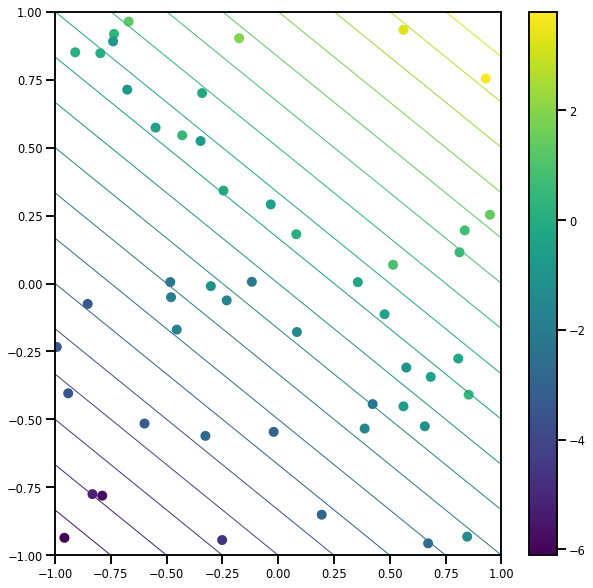

In [96]:
plt.figure(figsize=(10, 10))
plt.scatter(*xs, c=ys, s=100, linewidths=0)
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)